# **GEOG5990M Final Assignment**

Student ID number: 201966885

# **The relationship between population density and car ownership at the local authority level in England**

## **Introduction**

Car ownership is a key indicator of transport accessibility, social inequality,
and environmental sustainability. In densely populated urban areas, higher
accessibility to public transport and services may reduce reliance on private
cars, whereas lower-density areas often exhibit higher levels of car dependency.

Understanding how population density relates to car ownership is important for
urban planning, transport policy, and sustainability strategies in the UK.

This study investigates the relationship between population density and the
proportion of households without access to a car at the local authority level
in England, using official data from the Office for National Statistics (ONS)
and the 2021 Census.

## **Research Question**

This project addresses the following research questions:

**•Main research question**

Is population density associated with lower levels of household car ownership across local authority districts in England?

**•Sub-question**

Do more densely populated local authorities have a higher proportion of households with no access to a car or van?

## **Data**

**•Population density data**

Population density data were obtained from the Office for National Statistics
(ONS), measured as the number of residents per square kilometre at the lower-tier
local authority level. The 2021 estimates were used to ensure temporal
consistency with Census 2021 car ownership data.

https://www.ons.gov.uk/explore-local-statistics/indicators/population-density?utm_source=chatgpt.com#get-the-data

**•Car ownership data**

Car ownership data were derived from the 2021 Census (TS045 table), which reports
the number of cars or vans available to households. This study focuses on the
count of households with no car or van, aggregated to the local authority level.

https://www.ons.gov.uk/datasets/TS045/editions/2021/versions/4

**•Spatial boundary data**

https://www.data.gov.uk/dataset/af158609-c1ec-40a6-a8ee-0b0feb698463/local-authority-districts-december-2024-boundaries-uk-bgc?utm_source=chatgpt.com

**•Data integration**

All datasets were merged using a common identifier:

**Local authority district code (LAD code)**

Only local authorities present in both datasets were included in the statistical analysis.

## **Methods**

**•Data preprocessing**

All datasets were cleaned and prepared using Python (pandas and geopandas).
Local authority codes were standardised to ensure consistency across datasets.
Only observations with complete data for both population density and car ownership were retained.

In [63]:
# read in required packages
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt

In [64]:
POP_PATH = "/content/population-density-table-data.csv"
CAR_PATH = "/content/TS045-2021-4.csv"
BOUNDARY_PATH = "/content/Local_Authority_Districts_December_2024_Boundaries_UK_BGC_8568151832245726972.geojson"

In [65]:
boundaries = gpd.read_file(BOUNDARY_PATH).to_crs("EPSG:4326") # Read the boundary file and convert to EPSG:4326 (WGS84)
print(boundaries.crs) # Check the coordinate reference system
boundaries.head(3) # Preview the first few rows of the spatial dataset

EPSG:4326


,FID,LAD24CD,LAD24NM,LAD24NMW,BNG_E,BNG_N,LONG,LAT,GlobalID,geometry
0,1,E06000001,Hartlepool,,447161,531473,-1.27017,54.67613,b2299bd8-2f81-47c8-a203-f221a8660406,"MULTIPOLYGON (((-1.23 54.6251, -1.22989 54.625..."
1,2,E06000002,Middlesbrough,,451141,516887,-1.21100,54.54468,780afbcf-fa9e-4e4d-8170-1c4a5900e3fe,"MULTIPOLYGON (((-1.2771 54.54789, -1.27718 54...."
2,3,E06000003,Redcar and Cleveland,,464330,519596,-1.00657,54.56752,2a60d0ee-9a32-475e-9775-443544dfbe28,"MULTIPOLYGON (((-1.20097 54.57762, -1.20036 54..."


To enable spatial analysis and choropleth mapping, Local Authority District (LAD)
boundary data were loaded using GeoPandas. The coordinate reference system (CRS)
was converted to WGS84 (EPSG:4326) to ensure compatibility with other spatial data
and standard web mapping conventions.

In [66]:
print(boundaries.columns)

Index(['FID', 'LAD24CD', 'LAD24NM', 'LAD24NMW', 'BNG_E', 'BNG_N', 'LONG',
       'LAT', 'GlobalID', 'geometry'],
      dtype='object')


In this section, I define the file paths for the two datasets and the LAD boundary file.
Then I load the LAD boundary polygons and reproject them to WGS84 (EPSG:4326) to ensure
a consistent coordinate reference system for mapping and spatial operations.

In [67]:
#Define join key column names
LAD_CODE_COL = "LAD24CD"
LAD_NAME_COL = "LAD24NM"

To keep the notebook readable and reduce hard-coded strings, I store the LAD code
and LAD name column names in variables. These keys will later be used to merge
population density and car ownership measures onto the LAD polygons.

**Dataset A: Clean population density to keep only 202**3

In [68]:
# Preview the first lines
# The ONS CSV export includes metadata lines before the real table header.
# Printing the first 15 lines helps identify which row contains:
with open(POP_PATH, "r", encoding="utf-8", errors="ignore") as f:
  for i in range(15):
    print(f"{i}: {f.readline().rstrip()}")

0: ﻿"Population density"
1: "Number of people resident per square kilometre"
2: "Source: Office for National Statistics"
3: 
4: Data download generated by ONS Explore Local Statistics on 27 Jan 2026
5: https://ons.gov.uk/explore-local-statistics/indicators/population-density
6: 
7: Area code,Area name,1991,1992,1993,1994,1995,1996,1997,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023,2024
8: E06000001,Hartlepool,970,972,970,970,966,963,958,956,955,957,960,959,960,962,963,967,969,973,975,977,981,984,985,984,981,983,983,983,984,982,986,1003,1022,1046
9: E06000002,Middlesbrough,2686,2675,2681,2703,2717,2705,2682,2673,2654,2640,2621,2600,2581,2570,2571,2564,2565,2559,2548,2555,2568,2570,2572,2580,2591,2610,2621,2618,2638,2644,2671,2772,2851,2898
10: E06000003,Redcar and Cleveland,595,595,589,585,581,576,574,573,569,568,568,565,565,566,564,561,559,557,554,552,551,551,550,551,552,552,553,556,558,557,557,560,563,

Because the CSV file includes several metadata lines (title, description, source, and
download information) before the actual table header, the first step is to preview the
raw file content. This allows identification of the correct row index where the true
column headers

In [69]:
#Find the header row automatically (row that contains “Area code”)
header_row = None
with open(POP_PATH, "r", encoding="utf-8", errors="ignore") as f: # Open the CSV file line by line to search for the real table header
    for i, line in enumerate(f): # Convert the line to lowercase to avoid issues with capitalisation
        low = line.lower()
        if ("area code" in low) and ("area name" in low):  # The true header row should contain both "area code" and "area name"
            header_row = i
            break # Stop searching once the header row is found

print("Detected header row:", header_row)

Detected header row: 7


The population density CSV file exported from ONS contains several metadata rows before
the actual table header. Instead of hard-coding the header row index, this step
automatically detects the correct header row by searching for key column names
(*Area code* and *Area name*).

This approach improves the robustness and reproducibility of the workflow, ensuring
that the data can still be read correctly even if the number of metadata rows changes
in future downloads.

In [70]:
#Read with the detected header row
pop_raw = pd.read_csv(POP_PATH, header=header_row)
pop_raw.head(3)

,E06000002,Middlesbrough,2686,2675,2681,2703,2717,2705,2682,2673,...,2591,2610,2621.1,2618,2638,2644,2671,2772,2851,2898
0,E06000003,Redcar and Cleveland,595.0,595.0,589.0,585.0,581.0,576.0,574.0,573.0,...,552,552,553,556,558,557,557,560,563,568
1,E06000004,Stockton-on-Tees,855.0,860.0,865.0,865.0,864.0,867.0,869.0,875.0,...,955,958,961,964,961,958,961,980,994,1009
2,E06000005,Darlington,503.0,503.0,502.0,503.0,502.0,504.0,502.0,503.0,...,537,538,539,539,539,541,548,554,562,570


In [71]:
pop_raw.columns

Index(['E06000002', 'Middlesbrough', '2686', '2675', '2681', '2703', '2717',
       '2705', '2682', '2673', '2654', '2640', '2621', '2600', '2581', '2570',
       '2571', '2564', '2565', '2559', '2548', '2555', '2568', '2570.1',
       '2572', '2580', '2591', '2610', '2621.1', '2618', '2638', '2644',
       '2671', '2772', '2851', '2898'],
      dtype='object')

In [72]:
# Re-read the CSV using the detected header row
# The python engine is used to handle irregular CSV formatting
pop_raw = pd.read_csv(POP_PATH, header=header_row, engine="python")
pop_raw.shape

(359, 36)

In [73]:
# Store the total number of columns
# This will later be used to infer the number of year columns
n_cols = pop_raw.shape[1]
n_cols

36

In [74]:
# Create a list of years based on the number of columns
# The first two columns correspond to area code and area name
# Remaining columns represent annual population density values starting from 1991
years = list(range(1991, 1991 + (n_cols - 2)))
# Assign column names:
# - 'area_code' for the local authority code
# - 'area_name' for the local authority name
# - Year columns as strings (e.g. '1991', '1992', ...)
pop_raw.columns = ["area_code", "area_name"] + [str(y) for y in years]
pop_raw.head(3)


,area_code,area_name,1991,1992,1993,1994,1995,1996,1997,1998,...,2015,2016,2017,2018,2019,2020,2021,2022,2023,2024
0,E06000003,Redcar and Cleveland,595.0,595.0,589.0,585.0,581.0,576.0,574.0,573.0,...,552,552,553,556,558,557,557,560,563,568
1,E06000004,Stockton-on-Tees,855.0,860.0,865.0,865.0,864.0,867.0,869.0,875.0,...,955,958,961,964,961,958,961,980,994,1009
2,E06000005,Darlington,503.0,503.0,502.0,503.0,502.0,504.0,502.0,503.0,...,537,538,539,539,539,541,548,554,562,570


In [75]:
pop_2021 = pop_raw[["area_code", "area_name", "2021"]].copy()

pop_2021 = pop_2021.rename(columns={
    "area_code": "lad_code",
    "area_name": "lad_name",
    "2021": "pop_density_2021"
})

pop_2021.head()

,lad_code,lad_name,pop_density_2021
0,E06000003,Redcar and Cleveland,557
1,E06000004,Stockton-on-Tees,961
2,E06000005,Darlington,548
3,E06000006,Halton,1626
4,E06000007,Warrington,1169


This section prepares the population density dataset for analysis by:

• Assigning meaningful column names to the raw table

• Converting year columns into explicit labels (1991-2024)

• Extracting population density for a single reference year (2021)

• Standardising variable names for merging with other datasets

In [76]:
pop_2021["pop_density_2021"].describe()

,pop_density_2021
count,359.000000
mean,1619.520891
std,2419.595215
min,9.000000
25%,201.000000
50%,566.000000
75%,2220.000000
max,15817.000000


**Load Census 2021 car/van availability (TS045)**

This section introduces the household car or van availability dataset from the 2021 UK Census.
The dataset records the number of households in each Local Authority District (LAD) by car ownership category.

This dataset will later be aggregated to calculate the proportion of households with no access to a car or van, which serves as an indicator of transport dependence and accessibility.

In [77]:
car_raw = pd.read_csv(CAR_PATH)
car_raw.head()

,Lower tier local authorities Code,Lower tier local authorities,Car or van availability (5 categories) Code,Car or van availability (5 categories),Observation
0,E06000001,Hartlepool,-8,Does not apply,0
1,E06000001,Hartlepool,0,No cars or vans in household,12102
2,E06000001,Hartlepool,1,1 car or van in household,16635
3,E06000001,Hartlepool,2,2 cars or vans in household,9259
4,E06000001,Hartlepool,3,3 or more cars or vans in household,2934


In [78]:
# List all column names to identify key variables
# These include:
# - Local authority code and name
# - Car or van availability category (code and label)
# - Observation count (number of households)
car_raw.columns.tolist()

['Lower tier local authorities Code',
 'Lower tier local authorities',
 'Car or van availability (5 categories) Code',
 'Car or van availability (5 categories)',
 'Observation']

In [79]:
# Clean column names for easier filtering, grouping, and merging
# - lowercase
# - replace spaces/special characters with "_"
# - remove extra underscores
car_raw.columns = (
    car_raw.columns.astype(str)
    .str.strip()
    .str.lower()
    .str.replace(r"[^a-z0-9]+", "_", regex=True)
    .str.strip("_")
)

car_raw.columns.tolist()

['lower_tier_local_authorities_code',
 'lower_tier_local_authorities',
 'car_or_van_availability_5_categories_code',
 'car_or_van_availability_5_categories',
 'observation']

This step standardises column names in the car ownership dataset to ensure consistency and avoid errors in later data processing steps such as filtering, grouping, and merging. All column names are converted to lowercase, special characters are replaced with underscores, and unnecessary whitespace is removed.

In [80]:
car_raw.head(5)

,lower_tier_local_authorities_code,lower_tier_local_authorities,car_or_van_availability_5_categories_code,car_or_van_availability_5_categories,observation
0,E06000001,Hartlepool,-8,Does not apply,0
1,E06000001,Hartlepool,0,No cars or vans in household,12102
2,E06000001,Hartlepool,1,1 car or van in household,16635
3,E06000001,Hartlepool,2,2 cars or vans in household,9259
4,E06000001,Hartlepool,3,3 or more cars or vans in household,2934


In [81]:
# Inspect column names related to LAD identifiers
[c for c in car_raw.columns if "code" in c or "authority" in c or "lower" in c]
# Inspect column names related to car/van availability categories
[c for c in car_raw.columns if "car" in c or "van" in c or "availability" in c]
# Inspect column names related to household counts
[c for c in car_raw.columns if "observation" in c or "count" in c]

['observation']

This step inspects the cleaned column names to identify variables related to local authority codes, car availability categories, and household counts. Based on this inspection, the relevant columns are selected for subsequent aggregation and analysis.

In [82]:
# Identify key column names needed for aggregation
lad_code = "lower_tier_local_authorities_code"
CATEGORY_COL = "car_or_van_availability_5_categories_code"
OBS_COL = "observation"

To improve code readability and avoid hard-coding column names, key variables (local authority code, car availability category, and observation count) are stored as named constants. These will be used consistently in later grouping and merging steps.

In [83]:
car = car_raw[[
lad_code, CATEGORY_COL, OBS_COL]].copy() # Select required columns and create a working copy
car[OBS_COL] = pd.to_numeric(car[OBS_COL], errors="coerce") # Ensure household counts are numeric
car = car.dropna(subset=[lad_code, CATEGORY_COL, OBS_COL]) # Remove rows with missing LAD code, category, or observation

car.head()

,lower_tier_local_authorities_code,car_or_van_availability_5_categories_code,observation
0,E06000001,-8,0
1,E06000001,0,12102
2,E06000001,1,16635
3,E06000001,2,9259
4,E06000001,3,2934


This step selects the required variables, converts household counts to numeric values,
and removes incomplete records to ensure data quality before aggregation.

In [84]:
# Identify the "no car" rows
# In many TS045 extracts, no-car is coded as 0, and "does not apply" might be -8.
car[CATEGORY_COL].unique()[:20]

array([-8,  0,  1,  2,  3])

In [85]:
# Keep only meaningful categories:
# 0 = no cars
# 1,2,3 = 1 / 2 / 3+ cars
car_valid = car[car[CATEGORY_COL].isin([0, 1, 2, 3])].copy()

# Total households per LAD
total_hh = (
    car_valid.groupby(lad_code, as_index=False)[OBS_COL]
    .sum()
    .rename(columns={OBS_COL: "households_total"})
)


This step identifies valid car availability categories, removes non-applicable codes,
and calculates the total number of households in each local authority district (LAD).

In [86]:
# No car households per LAD
no_car = (
    car_valid[car_valid[CATEGORY_COL] == 0]
    .groupby(lad_code, as_index=False)[OBS_COL]
    .sum()
    .rename(columns={OBS_COL: "households_no_car"})
)

car_lad = total_hh.merge(no_car, on=lad_code, how="left")
car_lad["households_no_car"] = car_lad["households_no_car"].fillna(0)

car_lad["prop_no_car"] = car_lad["households_no_car"] / car_lad["households_total"]

car_lad.head()


,lower_tier_local_authorities_code,households_total,households_no_car,prop_no_car
0,E06000001,40930,12102,0.295676
1,E06000002,60263,19964,0.331281
2,E06000003,61638,15288,0.248029
3,E06000004,83756,18713,0.223423
4,E06000005,48918,12253,0.250480


This step calculates the number of households with no access to a car in each local authority district (LAD).  
It then combines this with the total number of households to derive the proportion of car-free households.

In [87]:
car_lad["prop_no_car"].describe()

,prop_no_car
count,331.000000
mean,0.210788
std,0.109603
min,0.078471
25%,0.137410
50%,0.183398
75%,0.249297
max,0.772033


In [88]:
# Rename LAD code column for consistency before merging
car_lad = car_lad.rename(columns={lad_code: "lad_code"})
# Merge population density data with car ownership data by LAD code
analysis = pop_2021.merge(car_lad, on="lad_code", how="inner")
analysis.head()

,lad_code,lad_name,pop_density_2021,households_total,households_no_car,prop_no_car
0,E06000003,Redcar and Cleveland,557,61638,15288,0.248029
1,E06000004,Stockton-on-Tees,961,83756,18713,0.223423
2,E06000005,Darlington,548,48918,12253,0.250480
3,E06000006,Halton,1626,55951,13309,0.237869
4,E06000007,Warrington,1169,90538,15776,0.174247


In this step, the cleaned population density data (2021) is merged with the car ownership dataset using the local authority district (LAD) code.  
This creates a single dataset for subsequent statistical analysis and mapping.

In [89]:
pop_2021["lad_code"].head(10)

,lad_code
0,E06000003
1,E06000004
2,E06000005
3,E06000006
4,E06000007
5,E06000008
6,E06000009
7,E06000010
8,E06000011
9,E06000012


In [90]:
car_lad["lad_code"].head(10)

,lad_code
0,E06000001
1,E06000002
2,E06000003
3,E06000004
4,E06000005
5,E06000006
6,E06000007
7,E06000008
8,E06000009
9,E06000010


In [91]:
# Calculate Pearson correlation between population density and no-car households
analysis[["pop_density_2021", "prop_no_car"]].corr()

,pop_density_2021,prop_no_car
pop_density_2021,1.000000,0.854952
prop_no_car,0.854952,1.000000


This section examines the relationship between population density and the proportion of households without access to a car.  
A Pearson correlation coefficient is calculated, followed by an inspection of the most densely populated local authorities.

In [92]:
# Identify local authorities with the highest population density
analysis.sort_values("pop_density_2021", ascending=False).head(10)[
    ["lad_code", "lad_name", "pop_density_2021", "prop_no_car"]
]

,lad_code,lad_name,pop_density_2021,prop_no_car
286,E09000030,Tower Hamlets,15817,0.663829
275,E09000019,Islington,14608,0.668795
268,E09000012,Hackney,13657,0.648863
276,E09000020,Kensington and Chelsea,11898,0.583144
278,E09000022,Lambeth,11851,0.580126
269,E09000013,Hammersmith and Fulham,11177,0.574560
284,E09000028,Southwark,10623,0.602753
281,E09000025,Newham,9704,0.516826
263,E09000007,Camden,9687,0.636456
288,E09000032,Wandsworth,9586,0.478598


In [93]:
# Merge population density (2021) with car ownership indicators by LAD code
analysis = pop_2021.merge(
    car_lad,
    on="lad_code",
    how="inner",
    validate="1:1"  # ensure one-to-one match between datasets
)

print("analysis:", analysis.shape)
analysis.head()

analysis: (312, 6)


,lad_code,lad_name,pop_density_2021,households_total,households_no_car,prop_no_car
0,E06000003,Redcar and Cleveland,557,61638,15288,0.248029
1,E06000004,Stockton-on-Tees,961,83756,18713,0.223423
2,E06000005,Darlington,548,48918,12253,0.250480
3,E06000006,Halton,1626,55951,13309,0.237869
4,E06000007,Warrington,1169,90538,15776,0.174247


The cleaned population density dataset is merged with the car ownership dataset using local authority codes.  
A one-to-one merge is enforced to ensure data consistency across both datasets.

**Load LAD boundaries and merge to create GeoDataFrame**

In [94]:
boundaries = gpd.read_file(BOUNDARY_PATH)
boundaries = boundaries.to_crs("EPSG:4326") # Reproject to WGS84 for mapping compatibility
boundaries.head(3)

,FID,LAD24CD,LAD24NM,LAD24NMW,BNG_E,BNG_N,LONG,LAT,GlobalID,geometry
0,1,E06000001,Hartlepool,,447161,531473,-1.27017,54.67613,b2299bd8-2f81-47c8-a203-f221a8660406,"MULTIPOLYGON (((-1.23 54.6251, -1.22989 54.625..."
1,2,E06000002,Middlesbrough,,451141,516887,-1.21100,54.54468,780afbcf-fa9e-4e4d-8170-1c4a5900e3fe,"MULTIPOLYGON (((-1.2771 54.54789, -1.27718 54...."
2,3,E06000003,Redcar and Cleveland,,464330,519596,-1.00657,54.56752,2a60d0ee-9a32-475e-9775-443544dfbe28,"MULTIPOLYGON (((-1.20097 54.57762, -1.20036 54..."


This step loads the official UK Local Authority District (LAD) boundary dataset and reprojects it to WGS84 (EPSG:4326) to ensure consistency with other spatial data and visualisation outputs.

In [95]:
# Find which column holds the LAD code in your boundary file
boundaries.columns.tolist()

['FID',
 'LAD24CD',
 'LAD24NM',
 'LAD24NMW',
 'BNG_E',
 'BNG_N',
 'LONG',
 'LAT',
 'GlobalID',
 'geometry']

In [96]:
BOUND_CODE_COL = "LAD24CD"
BOUND_NAME_COL = "LAD24NM"

In [97]:
# Merge spatial boundaries with analysis table using LAD code
gdf = boundaries.merge(analysis, left_on=BOUND_CODE_COL, right_on="lad_code", how="inner")
gdf.shape

(312, 16)

In this step, the cleaned analysis dataset is merged with the local authority
boundary GeoDataFrame using the Local Authority District (LAD) code.

An inner join is applied to ensure that only local authorities present in both
the spatial boundary file and the attribute dataset are retained. The resulting
GeoDataFrame (`gdf`) is used for subsequent spatial analysis and choropleth
mapping.

## **Data Visualisation**


**Spatial visualisation (choropleth)**

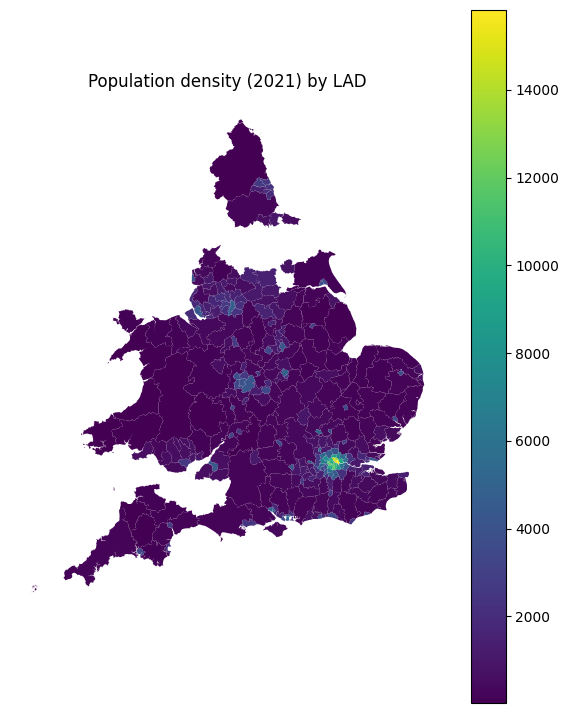

In [98]:
fig, ax = plt.subplots(1, 1, figsize=(7, 9)) # Create a figure and axis for the map
gdf.plot(column="pop_density_2021", ax=ax, legend=True) # Plot population density (2021) as a choropleth map
ax.set_title("Population density (2021) by LAD")
ax.axis("off")
plt.show()

This choropleth map shows population density across Local Authority Districts
(LADs) in England in 2021. Lighter colours (yellow–green) represent areas with
higher population density, while darker colours (purple) indicate lower
population density.

The map clearly highlights major urban areas such as London and other large
cities, which exhibit much higher population densities compared with rural
regions. This spatial pattern provides important context for analysing the
relationship between population density and household car ownership.

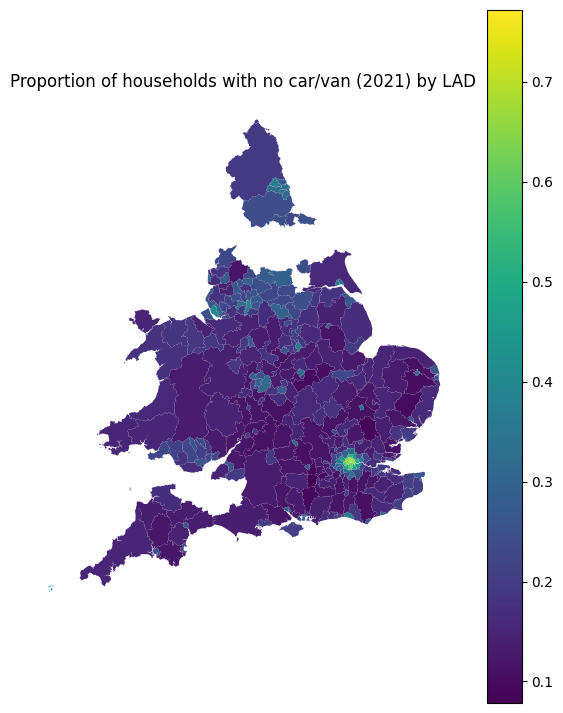

In [99]:
fig, ax = plt.subplots(1, 1, figsize=(7, 9))
gdf.plot(column="prop_no_car", ax=ax, legend=True)
ax.set_title("Proportion of households with no car/van (2021) by LAD")
ax.axis("off")
plt.show()

This choropleth map illustrates the proportion of households without access to
a car or van across Local Authority Districts (LADs) in England in 2021. Lighter
colours (yellow–green) represent a higher proportion of households with no car,
while darker colours (purple) indicate lower proportions.

High values are concentrated in London and other major urban areas, reflecting
greater reliance on public transport and higher residential density. In contrast,
rural and suburban districts generally show lower proportions of households
without a car.


**Non-spatial visualisation (scatter + trend)**

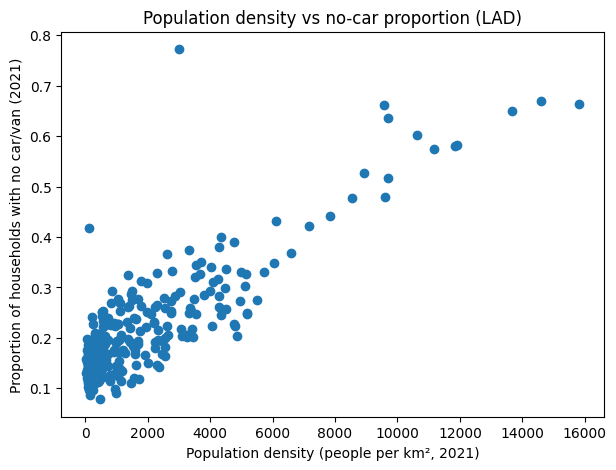

In [100]:
fig, ax = plt.subplots(1, 1, figsize=(7, 5))
ax.scatter(analysis["pop_density_2021"], analysis["prop_no_car"])
ax.set_xlabel("Population density (people per km², 2021)")
ax.set_ylabel("Proportion of households with no car/van (2021)")
ax.set_title("Population density vs no-car proportion (LAD)")
plt.show()

The figure presents a non-spatial scatter plot showing the relationship between
population density and the proportion of households without access to a car or
van across Local Authority Districts (LADs) in England in 2021.

The plot reveals a clear positive association: LADs with higher population
density tend to have a substantially higher proportion of households without
car ownership. Low-density areas cluster at the lower end of both variables,
while high-density urban areas, particularly in London, exhibit much higher
no-car proportions.

This pattern is consistent with the spatial distributions observed in the
choropleth maps and is supported by a strong positive Pearson correlation
coefficient (r ≈ 0.85).

**Results table**

We list the top and bottom LADs by:
- population density
- no-car proportion

In [101]:
top_density = analysis.sort_values("pop_density_2021", ascending=False).head(10)[
    ["lad_code", "lad_name", "pop_density_2021", "prop_no_car"]
]
low_density = analysis.sort_values("pop_density_2021", ascending=True).head(10)[
    ["lad_code", "lad_name", "pop_density_2021", "prop_no_car"]
]

top_density, low_density

(      lad_code                lad_name  pop_density_2021  prop_no_car
 286  E09000030           Tower Hamlets             15817     0.663829
 275  E09000019               Islington             14608     0.668795
 268  E09000012                 Hackney             13657     0.648863
 276  E09000020  Kensington and Chelsea             11898     0.583144
 278  E09000022                 Lambeth             11851     0.580126
 269  E09000013  Hammersmith and Fulham             11177     0.574560
 284  E09000028               Southwark             10623     0.602753
 281  E09000025                  Newham              9704     0.516826
 263  E09000007                  Camden              9687     0.636456
 288  E09000032              Wandsworth              9586     0.478598,
       lad_code         lad_name  pop_density_2021  prop_no_car
 310  W06000023            Powys                26     0.131036
 296  W06000008       Ceredigion                40     0.157344
 291  W06000002          G

In [102]:
top_no_car = analysis.sort_values("prop_no_car", ascending=False).head(10)[
    ["lad_code", "lad_name", "pop_density_2021", "prop_no_car"]
]
low_no_car = analysis.sort_values("prop_no_car", ascending=True).head(10)[
    ["lad_code", "lad_name", "pop_density_2021", "prop_no_car"]
]

top_no_car, low_no_car

(      lad_code                lad_name  pop_density_2021  prop_no_car
 257  E09000001          City of London              3007     0.772033
 275  E09000019               Islington             14608     0.668795
 286  E09000030           Tower Hamlets             15817     0.663829
 289  E09000033             Westminster              9578     0.662226
 268  E09000012                 Hackney             13657     0.648863
 263  E09000007                  Camden              9687     0.636456
 284  E09000028               Southwark             10623     0.602753
 276  E09000020  Kensington and Chelsea             11898     0.583144
 278  E09000022                 Lambeth             11851     0.580126
 269  E09000013  Hammersmith and Fulham             11177     0.574560,
       lad_code        lad_name  pop_density_2021  prop_no_car
 106  E07000089            Hart               466     0.078471
 94   E07000077      Uttlesford               143     0.087451
 36   E06000041       Wokingh

## **Results**

**Spatial patterns of population density and car ownership**

The choropleth maps reveal clear and contrasting spatial patterns across
England’s Local Authority Districts (LADs). Population density in 2021 is highly
concentrated in major urban areas, particularly Greater London and other large
metropolitan centres, while much of rural and suburban England exhibits
relatively low densities.

A similar spatial pattern is observed in the distribution of households without
access to a car or van. LADs with high population density tend to display a
substantially higher proportion of no-car households, whereas low-density areas
are dominated by car-owning households. The spatial coincidence of these two
patterns suggests a strong relationship between urban form and car ownership.

**Non-spatial relationship between population density and no-car households**

The scatter plot further confirms this relationship at the LAD level. Population
density shows a strong positive association with the proportion of households
without a car or van. This is supported by a high Pearson correlation coefficient
(r ≈ 0.85), indicating that LADs with higher population density consistently
exhibit higher levels of non-car ownership.

Together, the spatial and non-spatial results demonstrate a robust and coherent
relationship between population density and household car availability across
England.

## **Discussion**

The strong positive association observed between population density and the
proportion of households without access to a car aligns with broader research on
urban form and automobile dependence. Studies examining the dynamics of urban
form suggest that denser and more compact environments fundamentally alter travel
behaviour and car ownership decisions. Zegras (2012) argues that higher-density
urban settings reduce the necessity of private vehicle ownership by shortening
travel distances and supporting alternative modes of transport. This provides a
theoretical explanation for the findings in this study, where highly dense local
authority districts consistently exhibit higher proportions of car-free
households.

Empirical research further demonstrates that built environment characteristics,
including population density and transport-related infrastructure, are
statistically associated with car ownership behaviour. Using household-level
data, Yin, Shao and Wang (2018) show that factors such as residential density,
public transport accessibility, and parking availability significantly influence
both car ownership and car use, even after controlling for socio-economic
variables. These findings support the interpretation that population density in
this study may capture broader structural conditions, such as reduced parking
supply and improved public transport provision, which together discourage car
ownership in dense urban areas.

More recent research also highlights that the relationship between the built
environment and car ownership may not be strictly linear. Wu et al. (2023)
demonstrate that built environment characteristics, including population density,
exert nonlinear effects on household car ownership behaviour. Their findings
suggest that beyond certain density thresholds, the likelihood of car ownership
declines more rapidly as urban environments become increasingly compact and
transit-oriented. This helps explain the particularly high proportions of
car-free households observed in the most densely populated districts in this
analysis, especially within large metropolitan areas.


## **Limitation**

Several limitations should be acknowledged in interpreting the results of this
study. First, the analysis relies on cross-sectional data from a single year
(2021), which limits the ability to infer causal relationships between
population density and household car ownership. While a strong association is
observed, the direction of causality cannot be definitively established without
longitudinal data.

Additionally, the study does not explicitly control for socio-economic factors such
as income, age structure, housing tenure, or public transport accessibility,
which are known to influence car ownership. As a result, population density may
act as a proxy for these unobserved variables rather than being the sole driver of
the observed pattern.

## **Conclusion**

This study demonstrates a strong and consistent relationship between population
density and household car ownership across English Local Authority Districts.
High-density areas exhibit substantially higher proportions of households without
access to a car, a pattern confirmed through both spatial mapping and statistical
analysis.

These findings highlight the importance of urban form and transport
infrastructure in shaping sustainable mobility outcomes and provide evidence to
support density-focused planning and public transport investment strategies.

## **References**

1. Zegras, P. (2012). *Dynamics of Automobile Use and Urban Form*. MIT DSpace. [Accessed December 2012]. Available from:: https://dspace.mit.edu/handle/1721.1/100765

2. Yin, C., Shao, C. & Wang, X. (2018). *Built Environment and Parking Availability: Impacts on Car Ownership and Use*. Sustainability, 10(7). [Accessed July 2018]. Available from: https://www.mdpi.com/2071-1050/10/7/2285

3. Wu, L. et al. (2023). *Car Ownership Behavior Model Considering Nonlinear Impacts of Built Environment Characteristics*. Sustainability, 15(12). [Accessed June 2023]. Available from:: https://www.mdpi.com/2071-1050/15/12/9658


## **Acknowledgements**

I acknowledged the use of AI tools (ChatGPT5.2) for assistance with code debugging, data processing, and language translation.

In [103]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [104]:
!sudo apt-get install texlive-xetex texlive-fonts-recommended texlive-plain-generic pandoc

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
pandoc is already the newest version (2.9.2.1-3ubuntu2).
pandoc set to manually installed.
The following additional packages will be installed:
  dvisvgm fonts-droid-fallback fonts-lato fonts-lmodern fonts-noto-mono
  fonts-texgyre fonts-urw-base35 libapache-pom-java libcommons-logging-java
  libcommons-parent-java libfontbox-java libgs9 libgs9-common libidn12
  libijs-0.35 libjbig2dec0 libkpathsea6 libpdfbox-java libptexenc1 libruby3.0
  libsynctex2 libteckit0 libtexlua53 libtexluajit2 libwoff1 libzzip-0-13
  lmodern poppler-data preview-latex-style rake ruby ruby-net-telnet
  ruby-rubygems ruby-webrick ruby-xmlrpc ruby3.0 rubygems-integration t1utils
  teckit tex-common tex-gyre texlive-base texlive-binaries texlive-latex-base
  texlive-latex-extra texlive-latex-recommended texlive-pictures tipa
  xfonts-encodings xfonts-utils
Suggested packages:
  fonts-noto fonts-freefont-otf | fonts-fr

In [105]:
!jupyter nbconvert --to pdf "/content/drive/MyDrive/Colab Notebooks/GEOG5990M_Final_Project_template.ipynb"

[NbConvertApp] Converting notebook /content/drive/MyDrive/Colab Notebooks/GEOG5990M_Final_Project_template.ipynb to pdf
[NbConvertApp] Support files will be in GEOG5990M_Final_Project_template_files/
[NbConvertApp] Making directory ./GEOG5990M_Final_Project_template_files
[NbConvertApp] Writing 121743 bytes to notebook.tex
[NbConvertApp] Building PDF
[NbConvertApp] Running xelatex 3 times: ['xelatex', 'notebook.tex', '-quiet']
[NbConvertApp] Running bibtex 1 time: ['bibtex', 'notebook']
[NbConvertApp] WARNING | bibtex had problems, most likely because there were no citations
[NbConvertApp] PDF successfully created
[NbConvertApp] Writing 344476 bytes to /content/drive/MyDrive/Colab Notebooks/GEOG5990M_Final_Project_template.pdf
